# 0. Linear Classification Theory

The basis for data classification, and thus making decisions about the sample's class membership, can be the division of the feature space using surfaces that determine the boundaries of regions assigned to objects of different classes. These regions are called <font color=blue>decision regions</font> (ang. <font color=red>decision regions</font>), and the surfaces separating these regions are called <font color=blue>decision boundaries</font> (ang. <font color=red>decision boundary</font>).

If the decision boundaries are parametric, an attempt can be made to algorithmize their determination based on labeled sample datasets, so that they correctly define areas specific to a given class.
The simplest family of parametric surfaces are hyperplanes, i.e., linear surfaces. The simplest criterion for evaluating the quality of space division is a criterion based on assessing the average distance of samples from different classes to their expected positions, expressed by the mean squared error (MSE).

The simplest case of classification is a binary (two-class) problem. The presented geometric interpretation of classification—checking on which side of the hyperplane a given sample lies—corresponds to the problem of linear regression, where the labels of samples belonging to different classes are binary numbers, e.g., t∈{−1,1}.
The problem of finding the optimal separating hyperplane for two sets of samples then has an analytical solution of the form:

\begin{equation}
\boldsymbol{\theta}^* = \left( \mathbf{X} \mathbf{X}^T \right)^{-1} \mathbf{X} \mathbf{t}
\end{equation}

where 
X is the sample matrix (arranged in columns) and t is the vector of binary labels.

## 0.1. Implementation of analyze of results 

In [273]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import RidgeClassifier
from sklearn.datasets import make_moons #  to generate single-mode dataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

class ResultsAnalyzes:
    """ 
    A class to analyze and visualize the results of a binary classification model.

    Parameters:
        target (np.ndarray): The true labels.
        prediction (np.ndarray): The predicted labels.
    """

    def __init__(self, target: np.ndarray, prediction: np.ndarray):
        self.target = target
        self.prediction = prediction
        self._accuracy = None # Private atribute
        self._sensitivity = None
        self._specificity = None
        self._precision = None
        self._false_match_rate = None
        self._false_non_match_rate = None


    def confusion_matrix(self):
        """ Compute and plot the confusion matrix """
        cm = confusion_matrix(self.target, self.prediction)

        # Plot the confusion matrix using Seaborn
        plt.figure(figsize=(6,4))
        sns.heatmap(
            cm, 
            annot=True, # Displays the value in each cell
            fmt="d", # Format the values as integers
            cmap="Blues", # uses a blue color palette 
            cbar=False, # Hide the color bar
            xticklabels=["Predcited 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"]
        )
        
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion matrix")
        plt.show()


    @property 
    def accuracy(self) -> float:
        """ 
        Compute the accuracy of the predictions.
        
        Notes:
            Tells how many samples were well classified from all samples
        """
        return accuracy_score(self.target, self.prediction) 


    @property
    def sensitivity(self) -> float: 
        """ 
        Compute the sensivitty (recall) of the predictions. Sensitivity (Recall) = TP / (TP + FN) 
        
        Notes:
            Tell how many samples were predicted as True Positive from all Acutal Positive
        """
        
        return recall_score(self.target, self.prediction)


    @property
    def specificity(self) -> float: 
        """
        Compute the specificity of the predictions.  Specificity = TN / (TN + FP)

        Notes:
            Tell how many samples were predicted as True Negatives from all Acutal Negative
        """
        
        cm = confusion_matrix(self.target, self.prediction)
        self.tn, self.fp, self.fn, self.tp = cm.ravel() # ravel function in numpy is used to faltten a multi-dimensional array into a 1-dimensional array. It returns a contiguous flattened array, meaning it 
        # collapses the array into a single dimension while maintaining the order of the elements 
        specificity = self.tn / (self.tn + self.fp)
        return specificity
    

    def show_results(self):
        """ Display the accuracy, sensitivity and specificity of the predictions"""
        #self.accuracy = self._accuracy()
        #self.sensitivity = self._sensitivity()
        #self.specificity = self._specificity()
        print(f"Accuracy: {self.accuracy:.2f}, Sensivity: {self.sensitivity:.2f}, Specifity: {self.specificity:.2f}")

    
    def plot_ROC_curve(self, y_prediction_probability: np.ndarray):
        """
        Plot the Receiver Operaint Characteristic (ROC) curve.
        
        Parameters:
            y_prediction_probability (np.ndarray): The predicted probabilities for the positive class.
        """
        # Compute ORC curve and AUC
        fpr, tpr, thresholds = roc_curve(self.target, y_prediction_probability) # stands for False Positive Rate (1 - Specificity)  and True Positive Rate (Sensitivity)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC cruve (AUC = {roc_auc:.2f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characterstics Curve")
        plt.legend(loc="lower right")
        plt.show()

# 1. Implementation of classifier with Tichonov regularization

In [274]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import RidgeClassifier
from sklearn.datasets import make_moons #  to generate single-mode dataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# signle-mode datasets have only one cluster for one class

class ClassifierAnalyticalTichonow:
    """
    Linear classifier with Tikhonov (L2) regularization.

    Parameters:
        alpha: float, default=0.1

    Notes:
        Larger values specify stronger regularization = higher alpha
    """

    def __init__(self, alpha: float = 0.1) -> None:
        self.alpha = alpha

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Fit the model accroding to the given training data. 

        Parameters:
            X: ndarray of shape (n_samples, n_features)
            y: ndarray of shape (n_samples,). Target values
        """
        n_samples, n_features = X.shape
        if n_samples != len(y):
            raise ValueError("x and y must have the same number of samples")
        
        self.w = np.linalg.inv(X.T @ X + self.alpha * np.eye(n_features)) @ X.T @ y

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict class labels for samples in X.

        Parameters:
        X: ndarray of shape (n_samples, n_features). Test samples.
        
        Returns:
        y_pred : ndarray of shape (n_samples,) 
        """
        return np.sign(X @ self.w)

## 1.1. Training model on signle-mode datasets

### 1.1.1. Dataset make moons

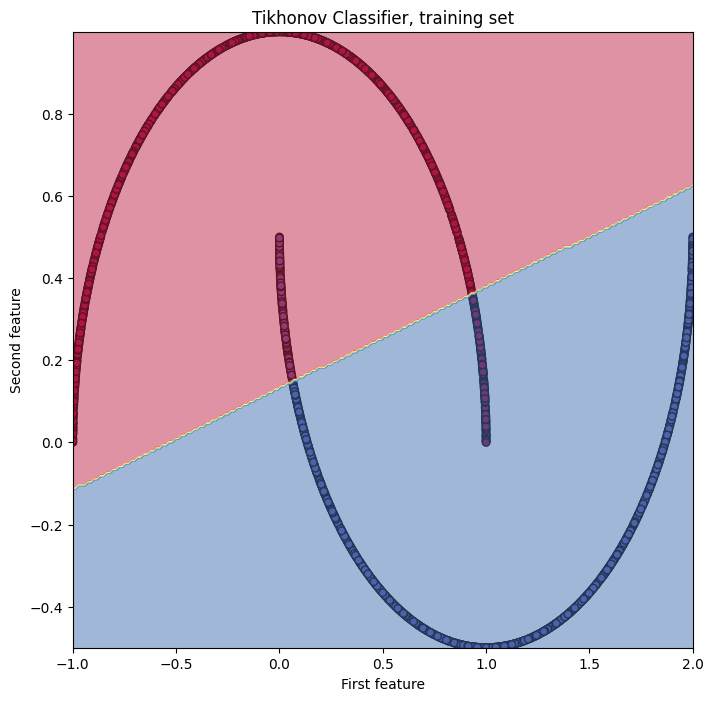

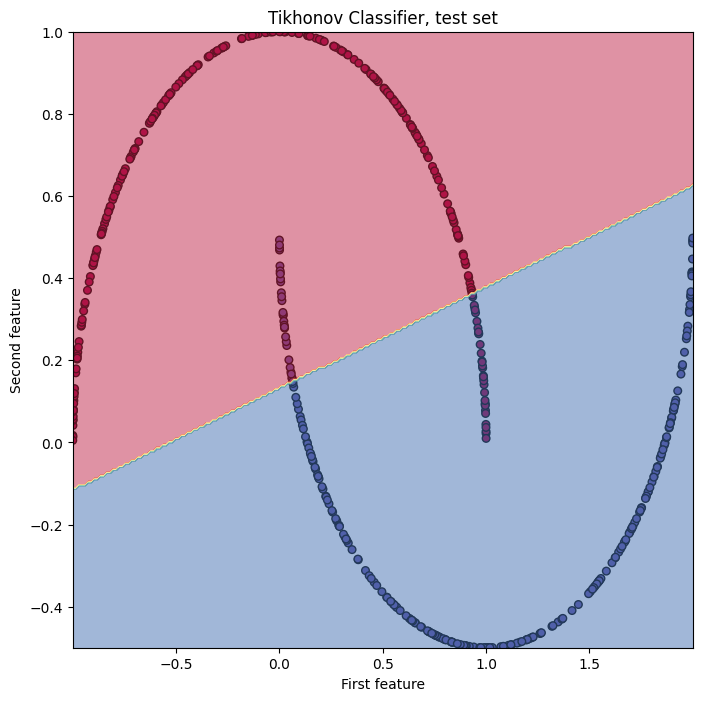

Accuracy: 0.88, Sensivity: 0.88, Specifity: 0.87


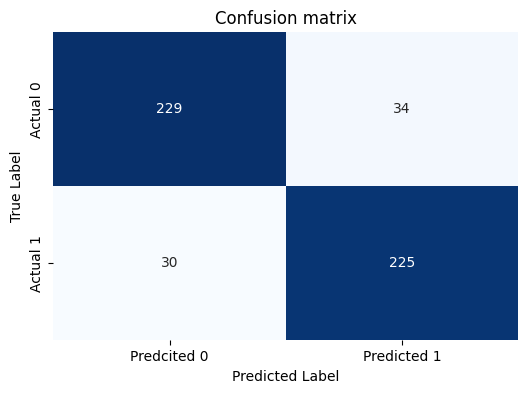

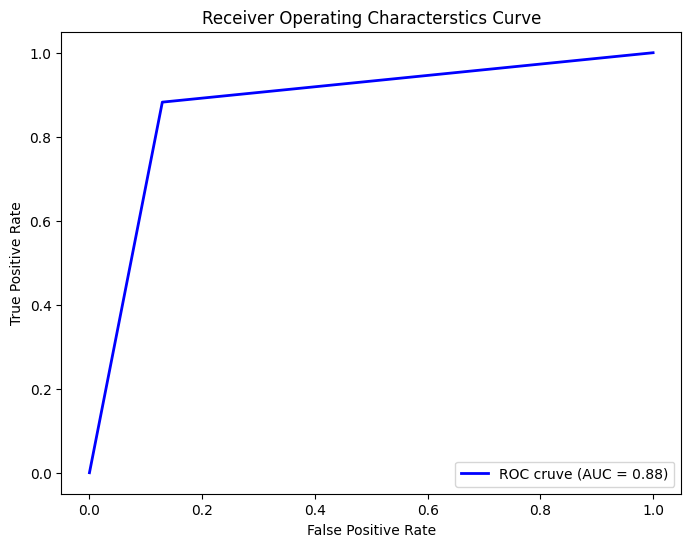

In [ ]:
x, t = make_moons(n_samples=2587, random_state=254687) # x - generated samples, t - targets(etykiety) 0 or 1 for each samples
# Make moons return as 'x' array with shape (n_samples, 2), where 2 = n_features
t[t==0] = -1 # those that had a value '0' now have a  value '1'

# Spliting datasets into Training and test set
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(x, t, test_size=0.2, random_state=254687)

# Adding a bias term 
X_train_moons = np.c_[np.ones((X_train_moons.shape[0], 1)), X_train_moons] # c_ is stacking arrays horizontally
X_test_moons = np.c_[np.ones((X_test_moons.shape[0], 1)), X_test_moons]

# Creating obcject, instance of class
classifier_own_moons = ClassifierAnalyticalTichonow() 

# Fit the classifier
classifier_own_moons.fit(X_train_moons, y_train_moons) 

# Making predictions
predictions_moons = classifier_own_moons.predict(X_test_moons) 

# Plot training dataset
plt.figure(figsize=(8,8))
plt.scatter(X_train_moons[:,1], X_train_moons[:,2], c = y_train_moons, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, training set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_train_moons[:,1].min(), X_train_moons[:,1].max()
y_min, y_max = X_train_moons[:,2].min(), X_train_moons[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_train = classifier_own_moons.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_train = Z_train.reshape(xx.shape) 

# plot the decision boundary for training dataset
plt.contourf(xx, yy, Z_train, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()

# Plot test dataset
plt.figure(figsize=(8,8))
plt.scatter(X_test_moons[:,1], X_test_moons[:,2], c = y_test_moons, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, test set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_test_moons[:,1].min(), X_test_moons[:,1].max()
y_min, y_max = X_test_moons[:,2].min(), X_test_moons[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_test = classifier_own_moons.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_test = Z_test.reshape(xx.shape) 

# plot the decision boundary for test dataset
plt.contourf(xx, yy, Z_test, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()

results = ResultsAnalyzes(y_test_moons, predictions_moons)
results.show_results()
results.confusion_matrix()
results.plot_ROC_curve(predictions_moons)

### 1.1.2. Dataset make classification

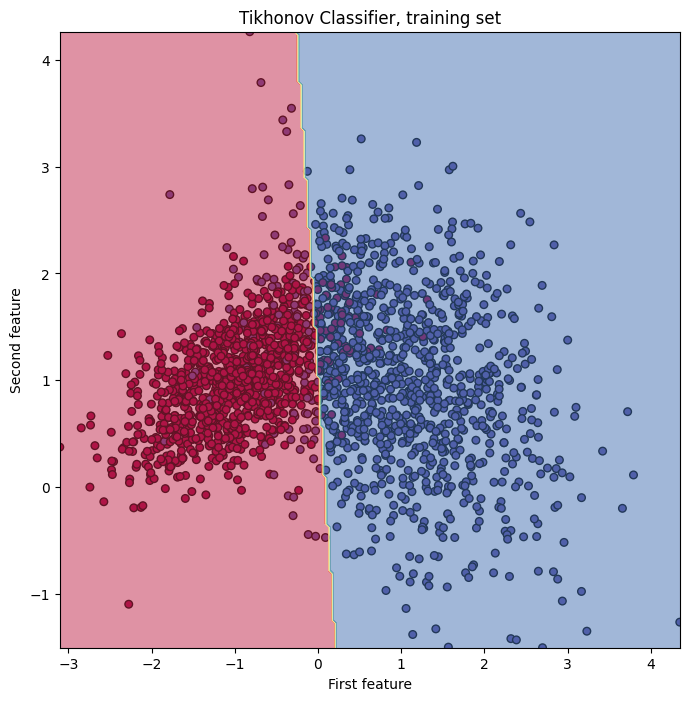

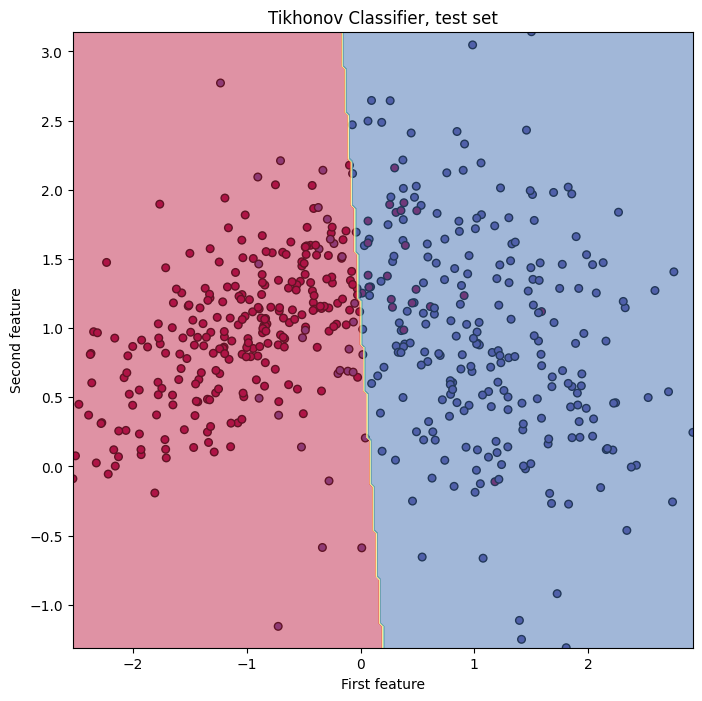

Accuracy: 0.90, Sensivity: 0.88, Specifity: 0.91


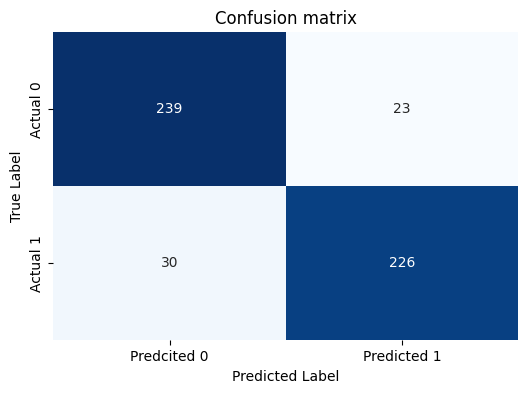

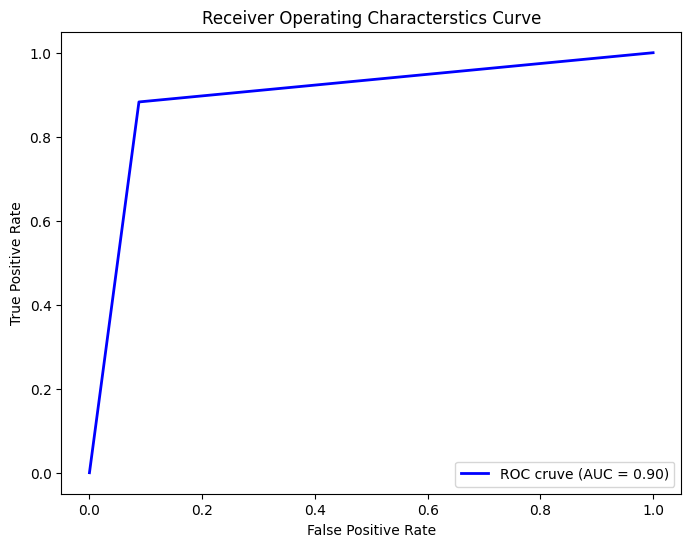

In [ ]:
X, y = make_classification(n_samples=2587, n_features=2, n_informative=2, n_clusters_per_class=1, n_classes=2, n_redundant=0, random_state=254687)
y[y==0] = -1

# Spliting datasets into Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=254687)

# Adding a bias term 
X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train] # c_ is stacking arrays horizontally
X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Creating obcject, instance of class
classifier_own = ClassifierAnalyticalTichonow() 

# Fit the classifier
classifier_own.fit(X_train, y_train) 

# Making predictions
predictions = classifier_own.predict(X_test) 

# Plot training dataset
plt.figure(figsize=(8,8))
plt.scatter(X_train[:,1], X_train[:,2], c = y_train, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, training set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_train[:,1].min(), X_train[:,1].max()
y_min, y_max = X_train[:,2].min(), X_train[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_train = classifier_own.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_train = Z_train.reshape(xx.shape) 

# plot the decision boundary for training dataset
plt.contourf(xx, yy, Z_train, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()


# Plot test dataset
plt.figure(figsize=(8,8))
plt.scatter(X_test[:,1], X_test[:,2], c = y_test, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, test set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_test[:,1].min(), X_test[:,1].max()
y_min, y_max = X_test[:,2].min(), X_test[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_test = classifier_own.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_test = Z_test.reshape(xx.shape) 

# plot the decision boundary for test dataset
plt.contourf(xx, yy, Z_test, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()

results = ResultsAnalyzes(y_test, predictions)
results.show_results()
results.confusion_matrix()
results.plot_ROC_curve(predictions)

Widać że granica decyzyjna nie jest satysfakcjonująca, dlatego też można zbudować nieliniową powierzchnię decyzyjną, ale zachowując liniowosc w przestrzeni parametrów

In [277]:
# X = np.ones((x.shape[0], 6))
# X[:,0] = x[:,0]*x[:,0] # x1*x1 # Im using samples from make moons
# X[:,1] = x[:,1]*x[:,1] # x2*x2
# X[:,2] = x[:,0]*x[:,1] # x1*x2
# X[:,3] = x[:,0] # x1
# X[:,4] = x[:,1] # x2

# # calculating a vector of parameters
# Theta = np.linalg.inv(X.T@X)@X.T@t

# z = Theta[0]*xx*xx + Theta[1]*yy*yy + Theta[2]*xx*yy + Theta[3]*xx + Theta[4]*yy + Theta[5]

# plt.scatter(x[t==1,0], x[t==1,1])
# plt.scatter(x[t==-1,0],x[t==-1,1])
# plt.contour(xx,yy,z, levels=[0]) # levels=[0] means decision boudary


# 2. Sklearn Ridge Classifier
## 2.1. Training model on signle-mode datasets

### 2.1.1. Dataset make moons

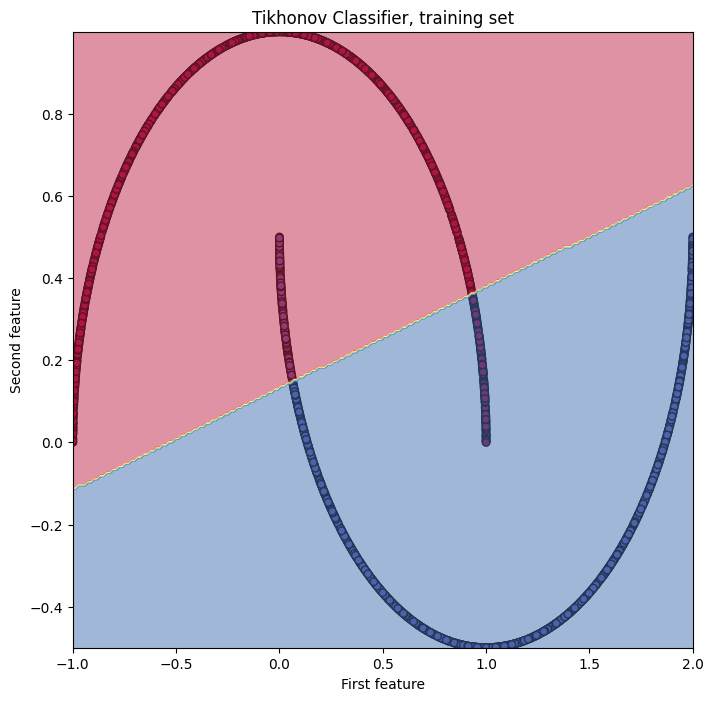

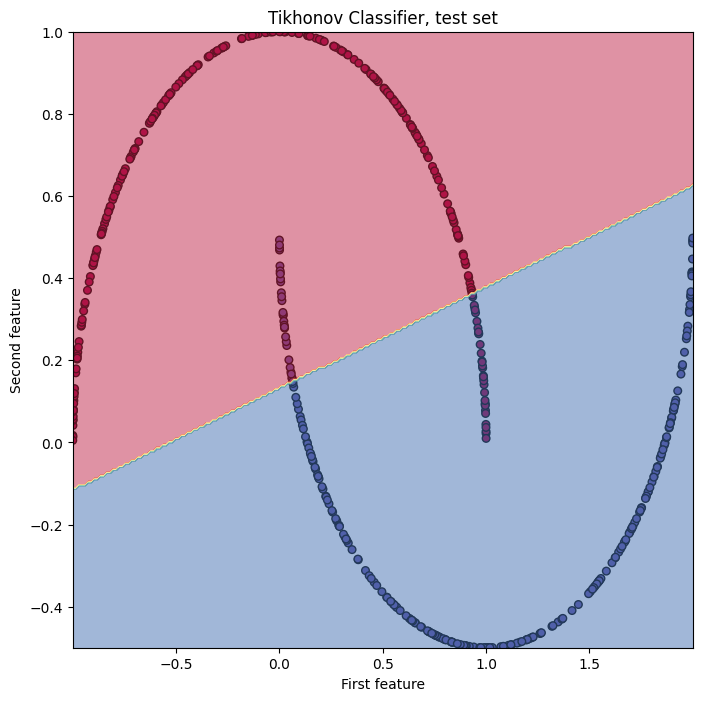

Accuracy: 0.88, Sensivity: 0.88, Specifity: 0.87


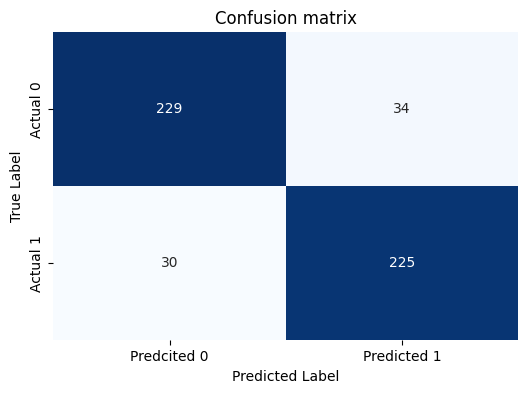

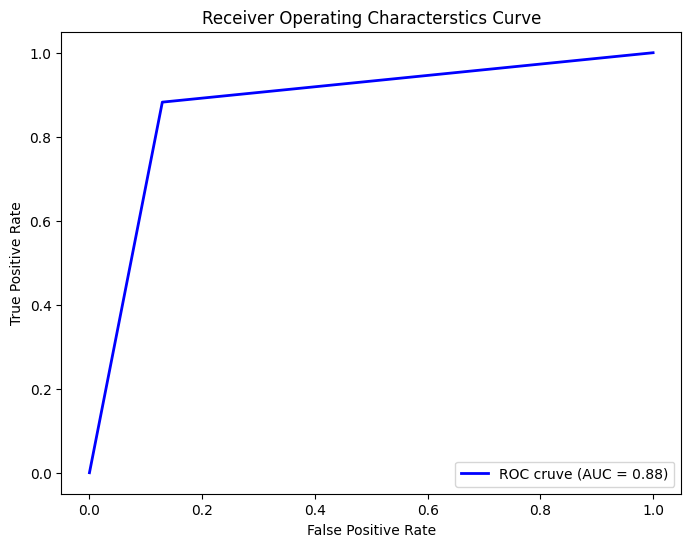

In [ ]:
x, t = make_moons(n_samples=2587, random_state=254687) # x - generated samples, t - targets(etykiety) 0 or 1 for each samples
# Make moons return as 'x' array with shape (n_samples, 2), where 2 = n_features
t[t==0] = -1 # those that had a value '0' now have a  value '1'

# Spliting datasets into Training and test set
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(x, t, test_size=0.2, random_state=254687)

# Adding a bias term 
X_train_moons = np.c_[np.ones((X_train_moons.shape[0], 1)), X_train_moons] # c_ is stacking arrays horizontally
X_test_moons = np.c_[np.ones((X_test_moons.shape[0], 1)), X_test_moons]

# Creating obcject, instance of class
classifier_moons = RidgeClassifier(alpha=0.1)

# Fit the classifier
classifier_moons.fit(X_train_moons, y_train_moons) 

# Making predictions
predictions_moons = classifier_moons.predict(X_test_moons) 

# Plot training dataset
plt.figure(figsize=(8,8))
plt.scatter(X_train_moons[:,1], X_train_moons[:,2], c = y_train_moons, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, training set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_train_moons[:,1].min(), X_train_moons[:,1].max()
y_min, y_max = X_train_moons[:,2].min(), X_train_moons[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_train = classifier_moons.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_train = Z_train.reshape(xx.shape) 

# plot the decision boundary for training dataset
plt.contourf(xx, yy, Z_train, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()

# Plot test dataset
plt.figure(figsize=(8,8))
plt.scatter(X_test_moons[:,1], X_test_moons[:,2], c = y_test_moons, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, test set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_test_moons[:,1].min(), X_test_moons[:,1].max()
y_min, y_max = X_test_moons[:,2].min(), X_test_moons[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_test = classifier_moons.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_test = Z_test.reshape(xx.shape) 

# plot the decision boundary for test dataset
plt.contourf(xx, yy, Z_test, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()

results = ResultsAnalyzes(y_test_moons, predictions_moons)
results.show_results()
results.confusion_matrix()
results.plot_ROC_curve(predictions_moons)

### 2.1.2. Dataset make classification

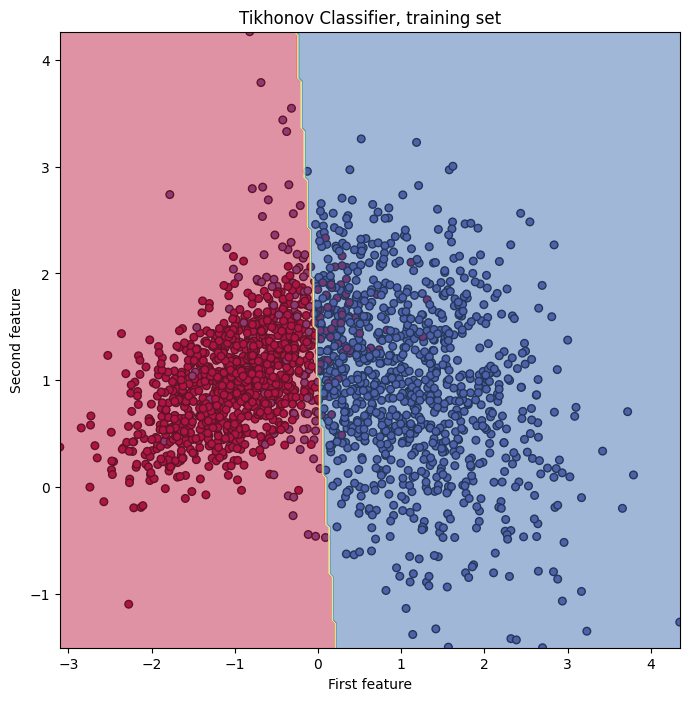

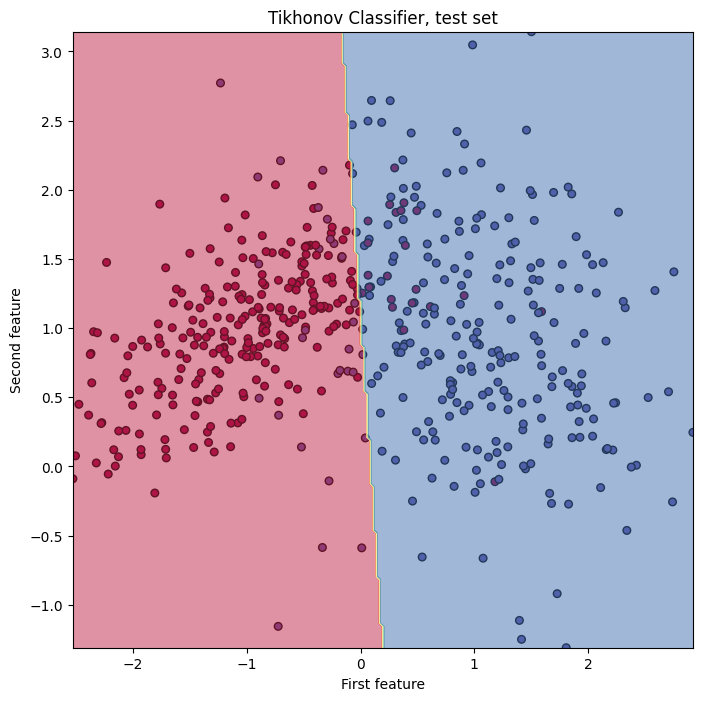

Accuracy: 0.90, Sensivity: 0.88, Specifity: 0.91


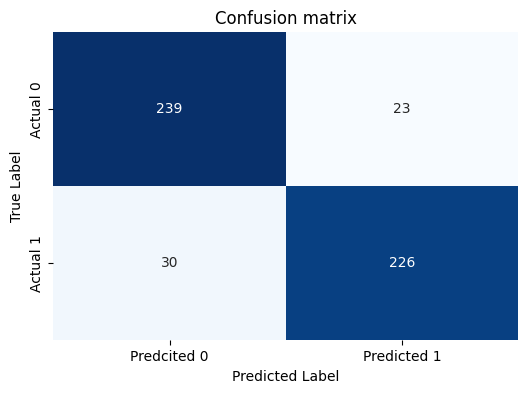

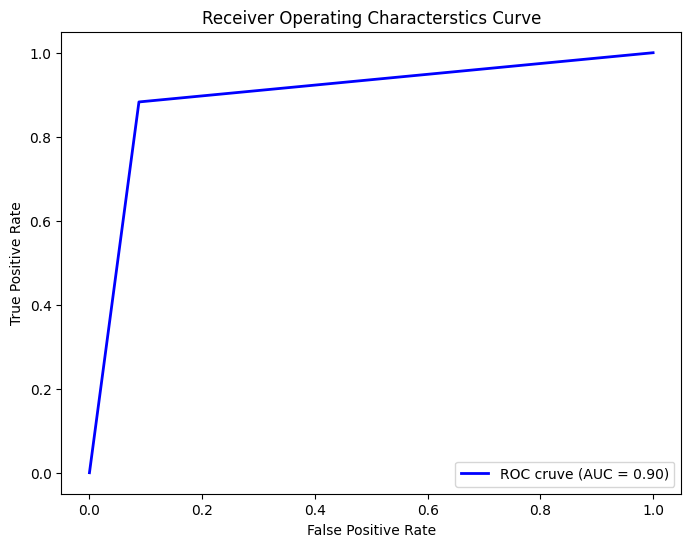

In [279]:
X, y = make_classification(n_samples=2587, n_features=2, n_informative=2, n_clusters_per_class=1, n_classes=2, n_redundant=0, random_state=254687)
y[y==0] = -1

# Spliting datasets into Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=254687)

# Adding a bias term 
X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train] # c_ is stacking arrays horizontally
X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Creating obcject, instance of class
classifier = RidgeClassifier() 

# Fit the classifier
classifier.fit(X_train, y_train) 

# Making predictions
predictions = classifier.predict(X_test) 

# Plot training dataset
plt.figure(figsize=(8,8))
plt.scatter(X_train[:,1], X_train[:,2], c = y_train, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, training set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_train[:,1].min(), X_train[:,1].max()
y_min, y_max = X_train[:,2].min(), X_train[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_train = classifier.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_train = Z_train.reshape(xx.shape) 

# plot the decision boundary for training dataset
plt.contourf(xx, yy, Z_train, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()


# Plot test dataset
plt.figure(figsize=(8,8))
plt.scatter(X_test[:,1], X_test[:,2], c = y_test, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, test set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_test[:,1].min(), X_test[:,1].max()
y_min, y_max = X_test[:,2].min(), X_test[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_test = classifier.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_test = Z_test.reshape(xx.shape) 

# plot the decision boundary for test dataset
plt.contourf(xx, yy, Z_test, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()

results = ResultsAnalyzes(y_test, predictions)
results.show_results()
results.confusion_matrix()
results.plot_ROC_curve(predictions)

Obie implementacje dały identyczne rezultaty

# Eksploracyjna analiza danych



In [280]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X_heart_disease = heart_disease.data.features
y_heart_disease = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [281]:
import pandas as pd
heart_disease_df = pd.concat([X_heart_disease, y_heart_disease], axis=1)
print(heart_disease_df.head())
print("\n\n")
print("Liczba brakujących wartości:\n",heart_disease_df.isnull().sum()) # counting the numer of missing values
heart_disease_df_pure = heart_disease_df.dropna() # deleting rows which have any missing values
plt.figure(figsize=(8,8))
heart_disease_df['num'] = heart_disease_df['num'].apply(lambda x: 1 if x!=0 else 0) # num as a predicted value is in range (0,4), thats why when I want binary value, I chose to change them as followed:
# 0 value (no presence of illness) is still zero, 1:4 -> 1

#unique_values = heart_disease_df['num'].unique() # uncover which values are in the 'num' column

import seaborn as sns

# Miary statystyczne dla wszystkich cech
print("Miary statystyczne dla wszystkich cech:")
statistics = heart_disease_df.describe().transpose()  # 'describe' returns: count number of samples without 'NaN', max, min, mean, std - standard deviation
print(statistics)




   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  num  
0  0.0   6.0    0  
1  3.0   3.0    2  
2  2.0   7.0    1  
3  0.0   3.0    0  
4  0.0   3.0    0  



Liczba brakujących wartości:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64
Miary statystyczne dla wszystkich cech:
          count        mean        std    min    25%    50%    75%    max
age       303.0   54.438944   9.03866

<Figure size 800x800 with 0 Axes>


Dominanta (tryb) dla każdej cechy:
age          58.0
sex           1.0
cp            4.0
trestbps    120.0
chol        197.0
fbs           0.0
restecg       0.0
thalach     162.0
exang         0.0
oldpeak       0.0
slope         1.0
ca            0.0
thal          3.0
num           0.0
Name: 0, dtype: float64
Kolumna 'tnum' nie została znaleziona w DataFrame.


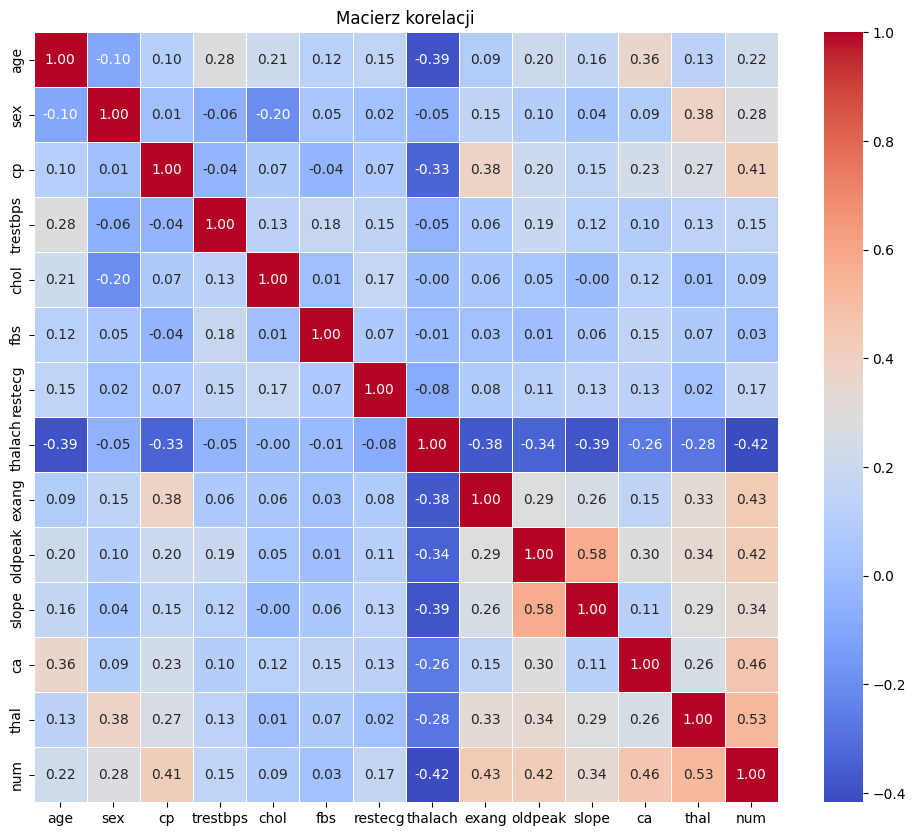

In [282]:


# Dominanta (tryb) dla każdej cechy
mode = heart_disease_df.mode().iloc[0]
print("\nDominanta (tryb) dla każdej cechy:")
print(mode)

# Histogramy wartości cech w zależności od wartości przewidywanej
target_column = 'tnum'  # Zakładam, że kolumna z wartościami przewidywanymi nazywa się 'target'
if target_column in heart_disease_df.columns:
    features = heart_disease_df.drop(columns=[target_column])
    for column in features.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data=heart_disease_df, x=column, hue=target_column, multiple='stack', bins=30)
        plt.title(f'Histogram wartości cechy {column} w zależności od {target_column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.legend(title=target_column)
        plt.show()
else:
    print(f"Kolumna '{target_column}' nie została znaleziona w DataFrame.")

# Macierz korelacji
plt.figure(figsize=(12, 10))
correlation_matrix = heart_disease_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title("Macierz korelacji")
plt.show()


Kategoryczne cechy:
Index([], dtype='object')

Ciągłe cechy:
Index(['oldpeak', 'ca', 'thal'], dtype='object')

Dyskretne cechy:
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'slope', 'num'],
      dtype='object')


C:\Users\pawel\AppData\Local\Temp\ipykernel_37244\3569670491.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_column)


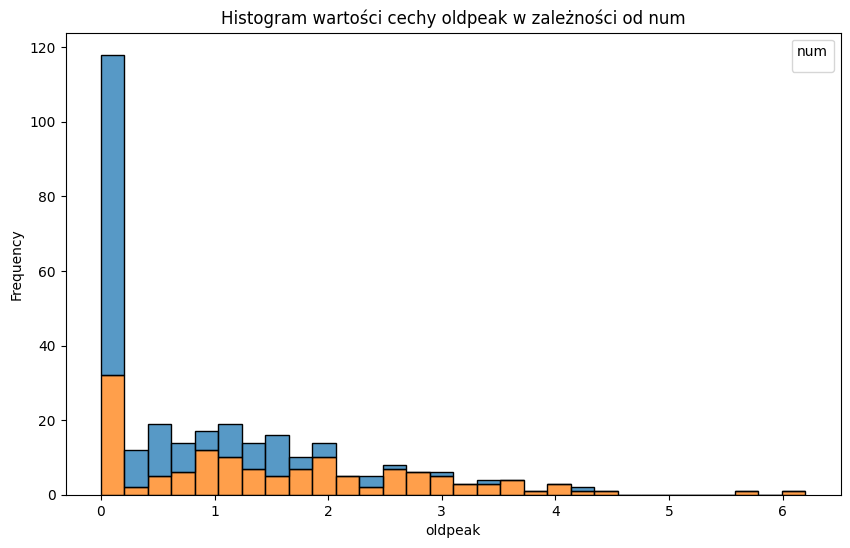

C:\Users\pawel\AppData\Local\Temp\ipykernel_37244\3569670491.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_column)


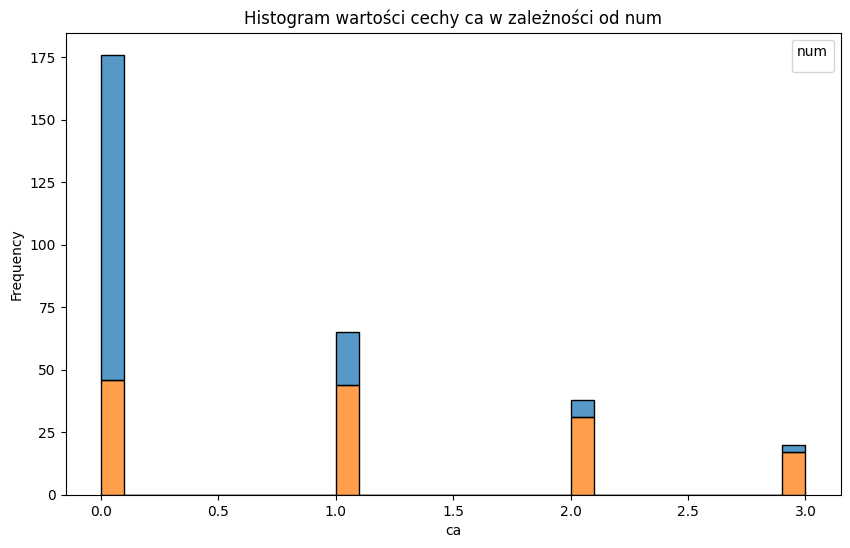

C:\Users\pawel\AppData\Local\Temp\ipykernel_37244\3569670491.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_column)


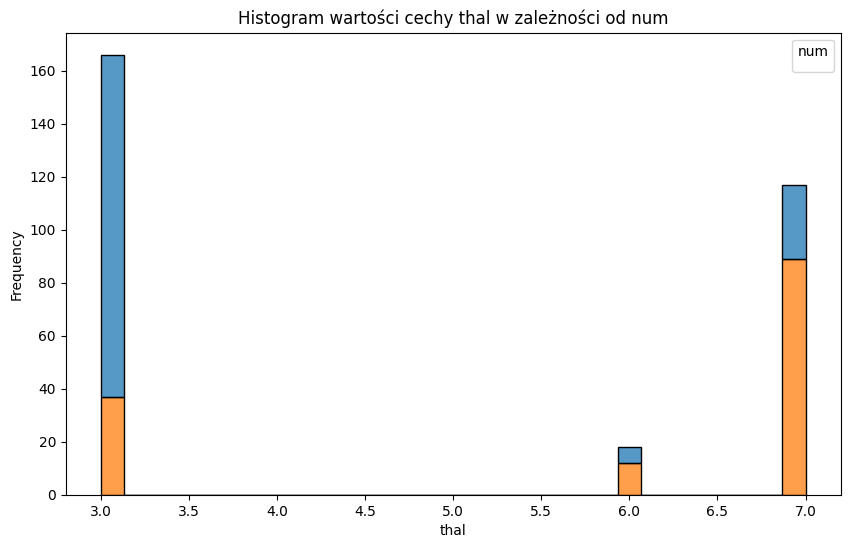

C:\Users\pawel\AppData\Local\Temp\ipykernel_37244\3569670491.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_column)


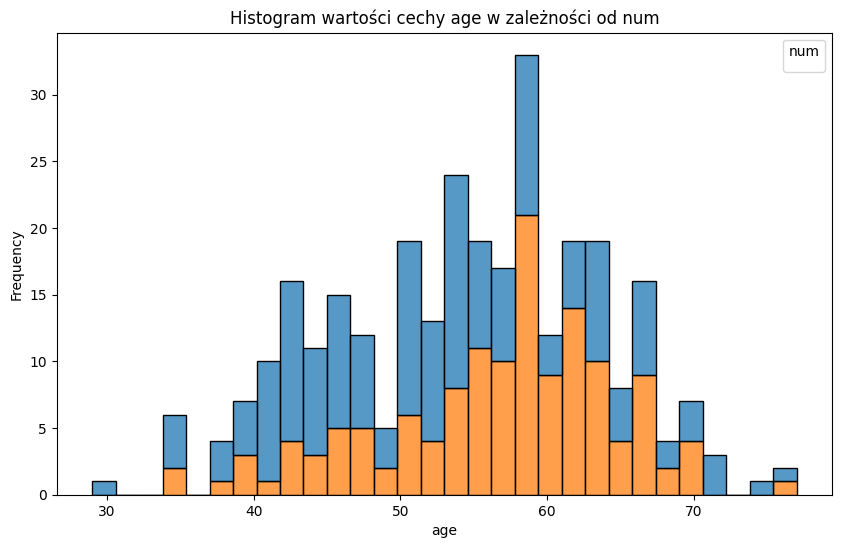

C:\Users\pawel\AppData\Local\Temp\ipykernel_37244\3569670491.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_column)


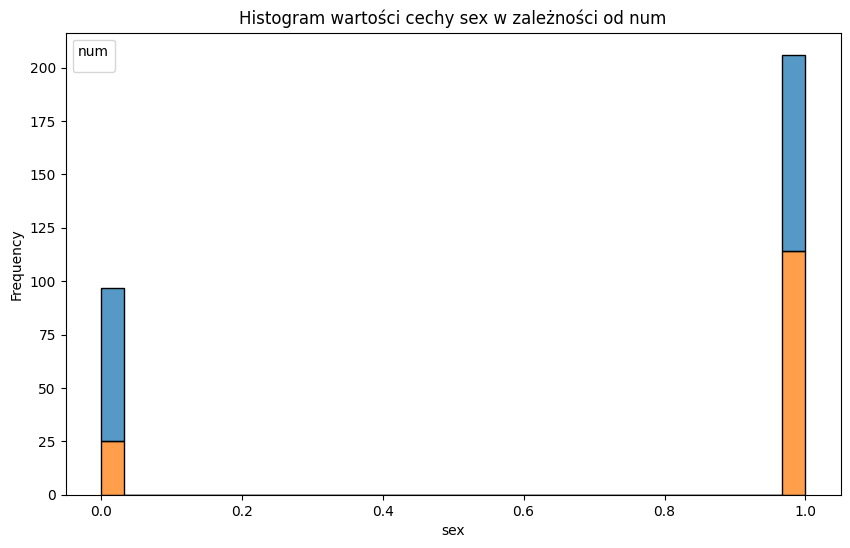

C:\Users\pawel\AppData\Local\Temp\ipykernel_37244\3569670491.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_column)


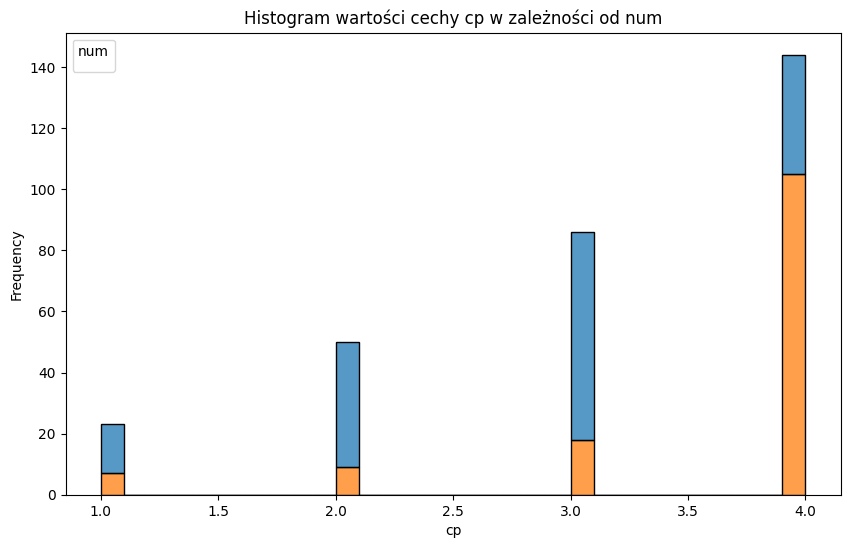

C:\Users\pawel\AppData\Local\Temp\ipykernel_37244\3569670491.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_column)


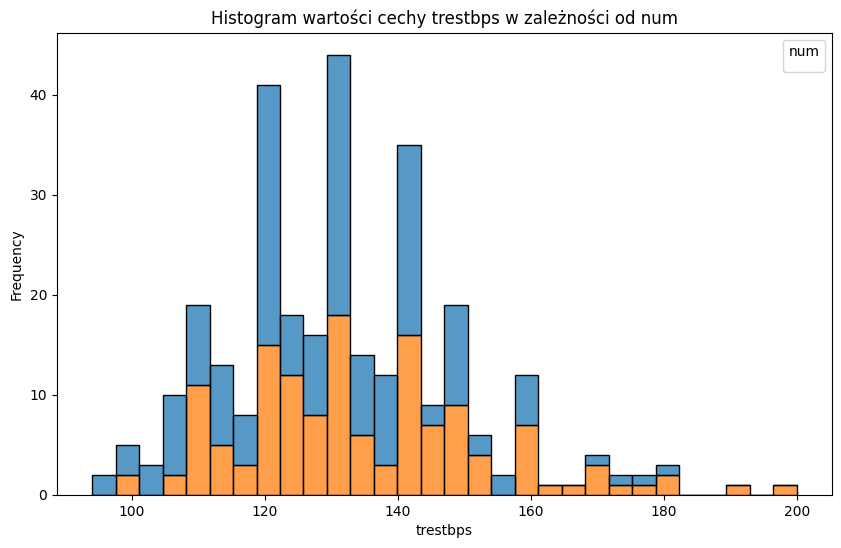

C:\Users\pawel\AppData\Local\Temp\ipykernel_37244\3569670491.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_column)


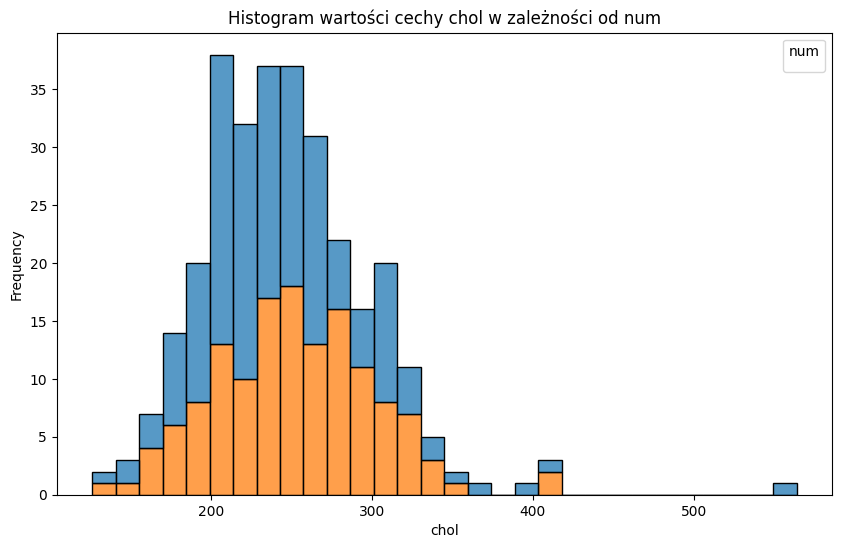

C:\Users\pawel\AppData\Local\Temp\ipykernel_37244\3569670491.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_column)


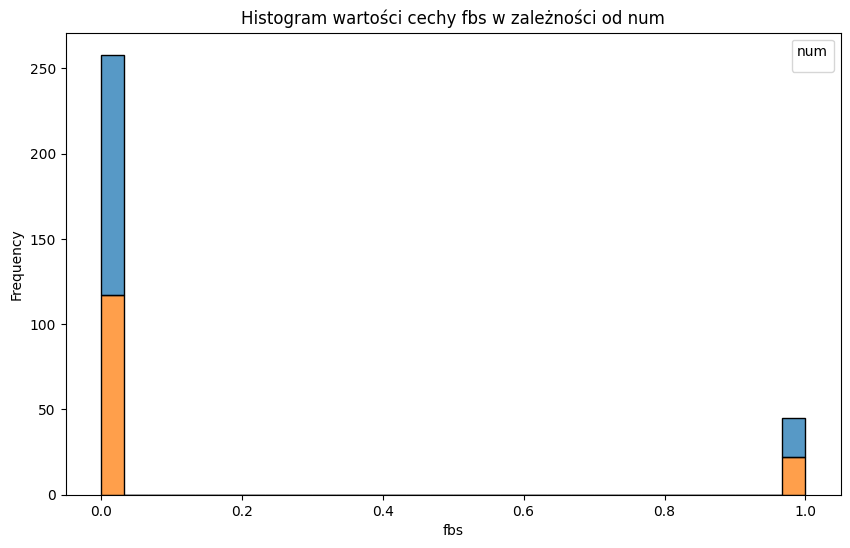

C:\Users\pawel\AppData\Local\Temp\ipykernel_37244\3569670491.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_column)


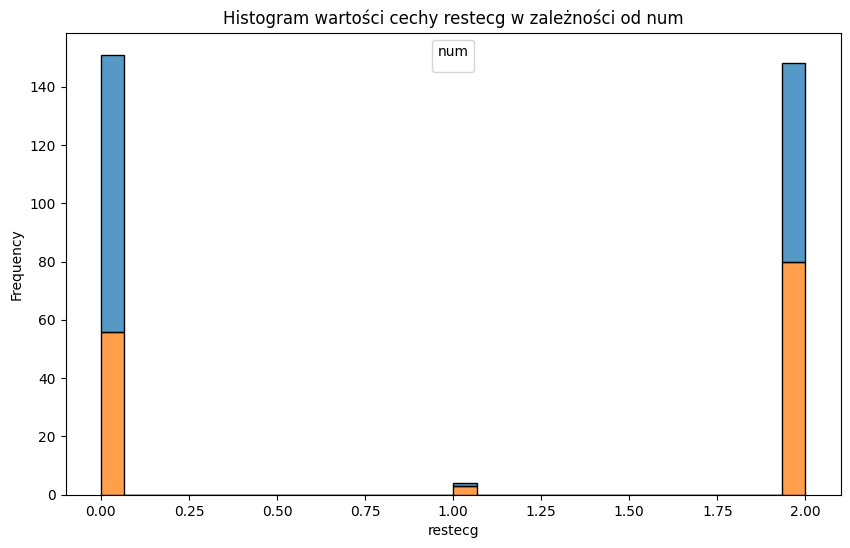

C:\Users\pawel\AppData\Local\Temp\ipykernel_37244\3569670491.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_column)


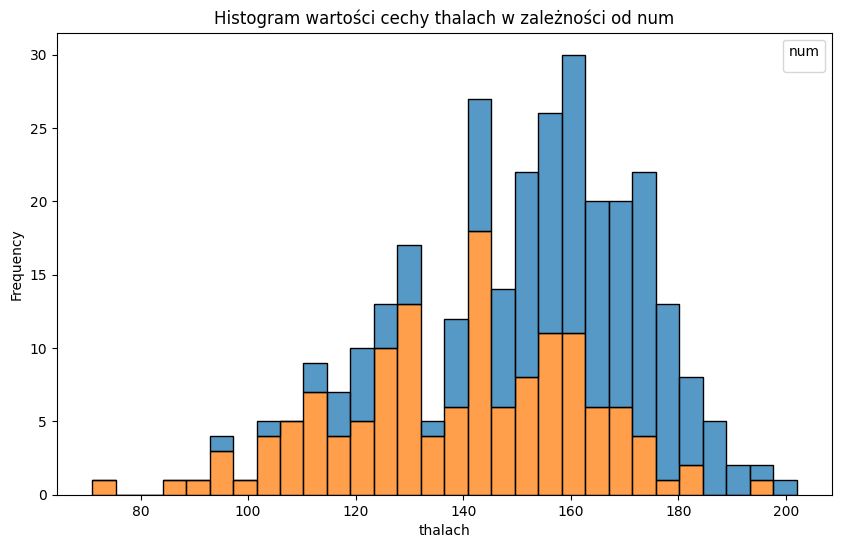

C:\Users\pawel\AppData\Local\Temp\ipykernel_37244\3569670491.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_column)


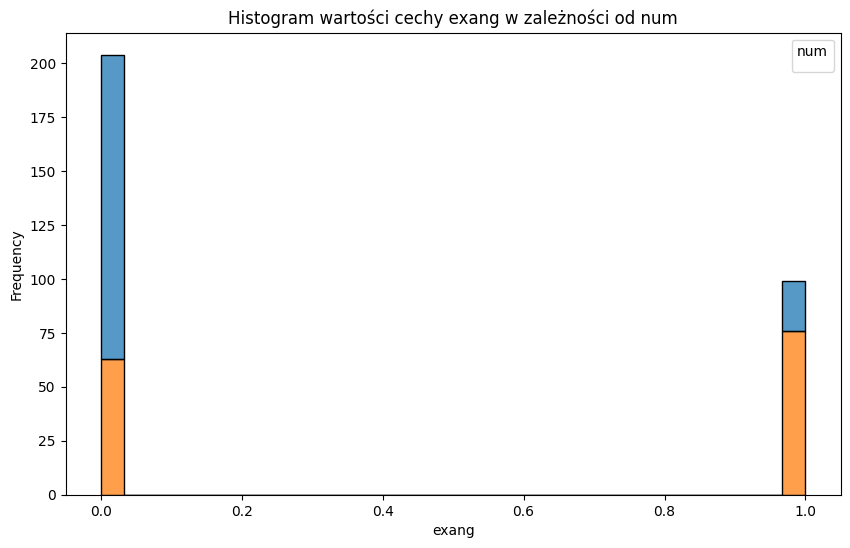

C:\Users\pawel\AppData\Local\Temp\ipykernel_37244\3569670491.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_column)


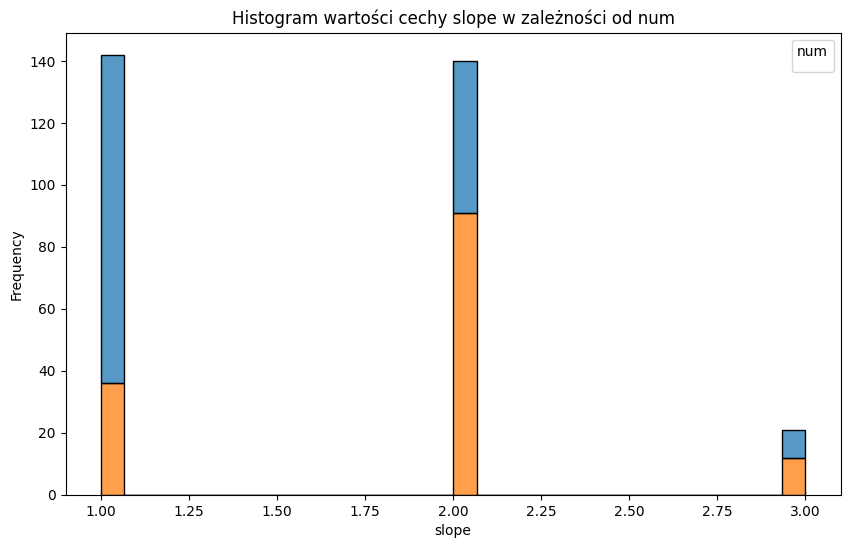

C:\Users\pawel\AppData\Local\Temp\ipykernel_37244\3569670491.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_column)


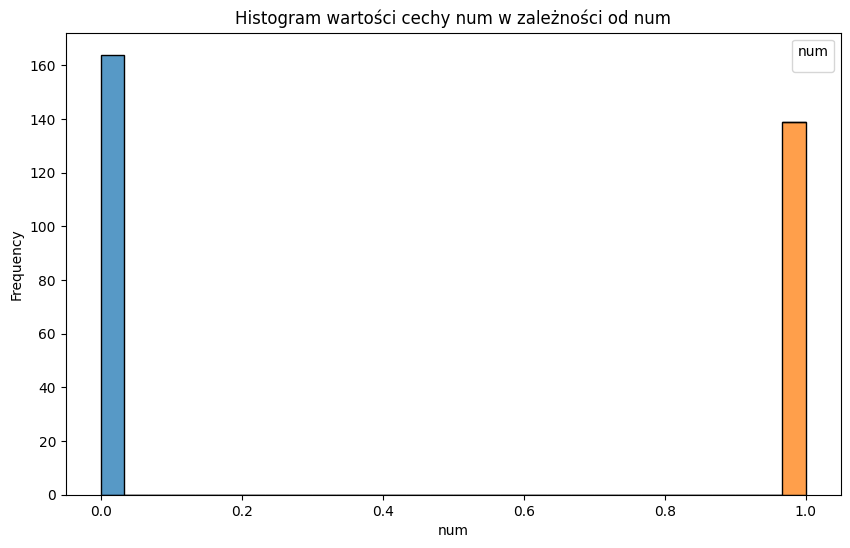

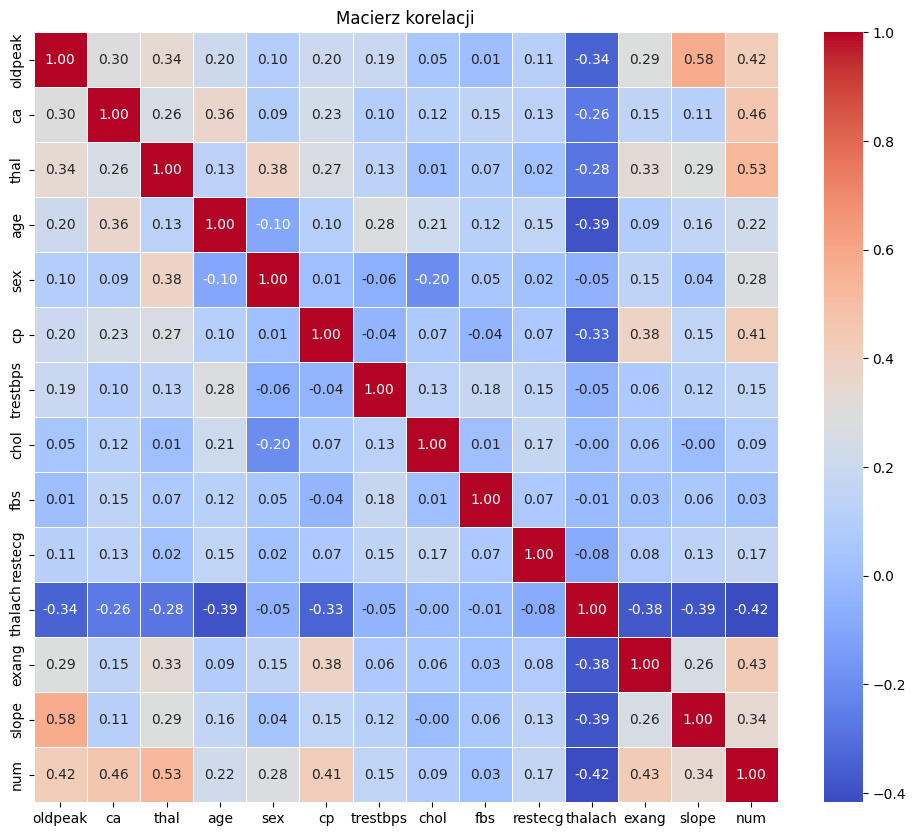

In [283]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Przykładowe dane (załaduj swoje dane w tym miejscu)
# heart_disease_df = pd.concat([X_heart_disease, y_heart_disease], axis=1)

# Klasyfikacja cech według typu
categorical_cols = heart_disease_df.select_dtypes(include=['object', 'category']).columns
continuous_cols = heart_disease_df.select_dtypes(include=['float64']).columns
discrete_cols = heart_disease_df.select_dtypes(include=['int64']).columns

print("Kategoryczne cechy:")
print(categorical_cols)
print("\nCiągłe cechy:")
print(continuous_cols)
print("\nDyskretne cechy:")
print(discrete_cols)

# Analiza cech kategorycznych
for col in categorical_cols:
    print(f"\nStatystyki dla cechy kategorycznej '{col}':")
    print(heart_disease_df[col].value_counts())

# Histogramy dla cech ciągłych i dyskretnych w zależności od wartości przewidywanej
target_column = 'num'  # Zakładam, że kolumna z wartościami przewidywanymi nazywa się 'target'
if target_column in heart_disease_df.columns:
    for col in continuous_cols.append(discrete_cols):
        plt.figure(figsize=(10, 6))
        sns.histplot(data=heart_disease_df, x=col, hue=target_column, multiple='stack', bins=30)
        plt.title(f'Histogram wartości cechy {col} w zależności od {target_column}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.legend(title=target_column)
        plt.show()
else:
    print(f"Kolumna '{target_column}' nie została znaleziona w DataFrame.")

# Macierz korelacji tylko dla cech numerycznych (ciągłych i dyskretnych)
numeric_cols = continuous_cols.append(discrete_cols)
plt.figure(figsize=(12, 10))
correlation_matrix = heart_disease_df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title("Macierz korelacji")
plt.show()
